
Node Labels: 
{0: 'Se_0', 1: '1_1', 2: 'C_2', 3: 'I_3'}

Standard Node Order: 
dict_values(['Se_0', '1_1', 'C_2', 'I_3'])

Port Addition Mask: 
[0 0 1 1 1 1 1 1 1]

 Causal Adjacency Mask: 
[[0 0 0 0]
 [0 1 1 0]
 [0 0 0 0]
 [0 1 1 0]]
25.0% of causal bond actions remain after filtering

 Power Flow Adjacency Mask: 
[[0 1 1 1]
 [0 1 1 1]
 [0 0 0 0]
 [0 0 0 0]]
37.5% of power flow bond addition actions remain after filtering


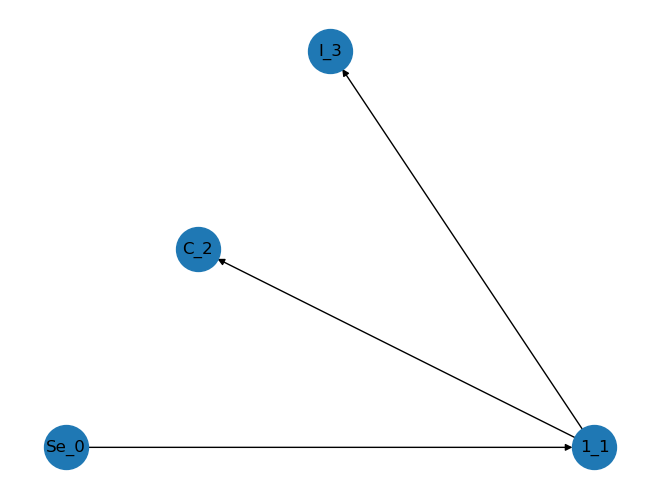

In [81]:
import networkx as nx
import scipy as sp
from bond_graph import *
import time
%reload_ext autoreload
%autoreload 2


G = BondGraph(max_nodes=20, num_states=2)
G.add_element(EffortSource(np.array([1, 2, 3])))
G.add_element(OneJunction())
G.add_bond(0, 1, 1)
G.add_element(Capacitance(capacitance=10))
G.add_bond(1, 2, 1)
G.add_element(Inertance(inertance=10))
G.add_bond(1, 3, 1)
G.add_element(Capacitance(capacitance=5))
G.add_bond(1, 4, 1)
# G.add_element(Capacitance(capacitance=10))

# print(list(G.graph.nodes(data=True)))
# print(G.graph.nodes['1_1']['node'].element_type)


labels = nx.get_node_attributes(G.graph, 'element_label')

nx.draw_planar(G.graph, labels=labels, with_labels=True, node_size=1000)

## Time to access energy storage elements (custom class vs. networkx)
# start = time.time()
# energy_storage_elements = G.get_energy_storage_elements()
# end = time.time()

# print(energy_storage_elements)
# print("Custom BG Class Elapsed Time: ", end - start)


# start = time.time()
# energy_storage_elements = [x for x,y in G.graph.nodes(data=True) if y['port_type'] == BondGraphPortTypes.CAPACITANCE or y['port_type'] == BondGraphPortTypes.INERTANCE]
# end = time.time()

# print("Networkx Elapsed Time: ", end - start)
# print(energy_storage_elements)

# print(G.graph.nodes)
# print(nx.to_numpy_array(G.graph))
# print(G.get_port_addition_mask())

print("\nNode Labels: ")
print(labels)


print("\nStandard Node Order: ")
# print(G.graph.nodes)
print(labels.values())

print("\nPort Addition Mask: ")
print(G.get_element_addition_mask())

causal_adjacency_mask, power_flow_adjacency_mask = G.get_bond_addition_mask()
print("\n Causal Adjacency Mask: ")
print(causal_adjacency_mask)
percent_fill=np.count_nonzero(causal_adjacency_mask)/np.size(causal_adjacency_mask)
print(f"{percent_fill*100}% of causal bond actions remain after filtering")

print("\n Power Flow Adjacency Mask: ")
print(power_flow_adjacency_mask)
percent_fill=np.count_nonzero(power_flow_adjacency_mask)/np.size(power_flow_adjacency_mask)
print(f"{percent_fill*100}% of power flow bond addition actions remain after filtering")



In [ ]:
from sympy import *

params = {"x":1, "y":2}
vars = symbols(list(params.keys()))

print(y)
# for key, value in enumerate(params):
#     vars[key] = params[key]


In [15]:

import itertools
from itertools import permutations 

max_nodes = 3
possible_edge_list = permutations(range(max_nodes), 2)

print(list(possible_edge_list))

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


In [11]:
import networkx as nx
G = nx.DiGraph()
G.add_node(1, x={'a':1, 'b':2})
G.add_node(2)
G.add_node(3, bond_type='causal')

print(G.nodes)

# print(list(G.nodes.data()))
# for node_data in G.nodes.data():
#     print(node_data)

[1, 2, 3]


In [183]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
num_node_types = 3
max_nodes = 3
""
add_edge_or_node = spaces.Discrete(2)
node_type_space = spaces.Discrete(num_node_types)
mask = (np.array([1, 0, 0], dtype=np.int8), np.array([1, 1, 1] , dtype=np.int8), np.array([1, 1], dtype=np.int8))
print(mask)
edge_type_space = spaces.MultiDiscrete([max_nodes, max_nodes, 2]) 

edge_type_space.sample(mask=mask)

# action_space = spaces.tuple(node_type_space, edge_type_space)
# action_space.sample(num_nodes=1, num_edges=1)

        

(array([1, 0, 0], dtype=int8), array([1, 1, 1], dtype=int8), array([1, 1], dtype=int8))


array([0, 2, 0])

In [12]:
from bond_graph_nodes import *

es = EffortSource(np.array([1, 2, 3]))
print(es.causality)
print(es.params)



None
{}


In [37]:
array = np.full([5,5], 1)
print(array)
array[1] = 0
print(array)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[1 1 1 1 1]
 [0 0 0 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
